## Import libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import math
from torch.utils.data import TensorDataset, random_split, DataLoader
import torch.nn.functional as F
from tqdm.notebook import trange, tqdm
from torchinfo import summary
from scipy.interpolate import interp1d, BSpline, splrep
from csaps import csaps
from skfda.representation.interpolation import SplineInterpolation
from scipy.interpolate import UnivariateSpline
from tslearn.metrics import SoftDTWLossPyTorch
from torch.utils.data import DataLoader, TensorDataset
from scipy.spatial.distance import cdist
import seaborn as sns
from depth.multivariate import *
from scipy import stats
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)


data_path_name = '/Users/micheledisabato/Documents/gait_data/' # change this to the path to the dataset
# https://springernature.figshare.com/collections/GaitRec_A_large-scale_ground_reaction_force_dataset_of_healthy_and_impaired_gait/4788012/1

/Users/micheledisabato/Library/Python/3.9/lib/python/site-packages/tslearn/bases/bases.py:15: UserWarning: h5py not installed, hdf5 features will not be supported.
Install h5py to use hdf5 features: http://docs.h5py.org/
  warn(h5py_msg)


Import and plot the dataset

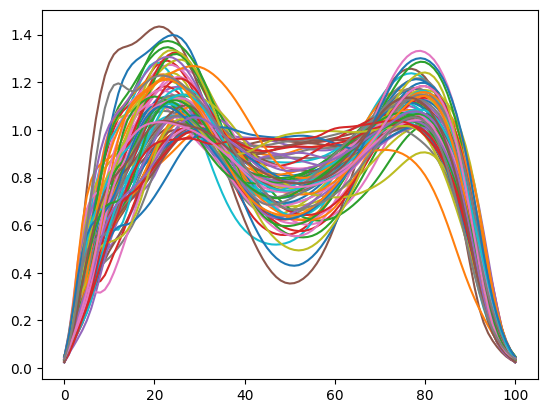

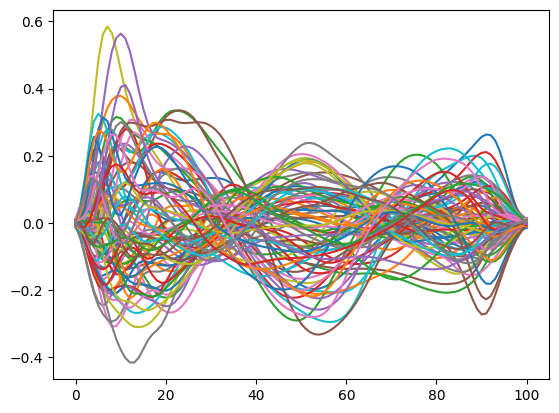

In [2]:
# # Left lower extremity
# GRF_F_V_PRO_left = pd.read_csv(data_path_name + 'GRF_F_V_PRO_left.csv')
# GRF_F_V_RAW_left = pd.read_csv(data_path_name + 'GRF_F_V_RAW_left.csv')

# GRF_F_AP_PRO_left = pd.read_csv(data_path_name + 'GRF_F_AP_PRO_left.csv')
# GRF_F_AP_RAW_left = pd.read_csv(data_path_name + 'GRF_F_AP_RAW_left.csv')

# GRF_F_ML_PRO_left = pd.read_csv(data_path_name + 'GRF_F_ML_PRO_left.csv')
# GRF_F_ML_RAW_left = pd.read_csv(data_path_name + 'GRF_F_ML_RAW_left.csv')

# GRF_COP_AP_PRO_left = pd.read_csv(data_path_name + 'GRF_COP_AP_PRO_left.csv')
# GRF_COP_AP_RAW_left = pd.read_csv(data_path_name + 'GRF_COP_AP_RAW_left.csv')

# GRF_COP_ML_PRO_left = pd.read_csv(data_path_name + 'GRF_COP_ML_PRO_left.csv')
# GRF_COP_ML_RAW_left = pd.read_csv(data_path_name + 'GRF_COP_ML_RAW_left.csv')

# # Right lower extremity
GRF_F_V_PRO_right = pd.read_csv(data_path_name + 'GRF_F_V_PRO_right.csv')
# GRF_F_V_RAW_right = pd.read_csv(data_path_name + 'GRF_F_V_RAW_right.csv')

# GRF_F_AP_PRO_right = pd.read_csv(data_path_name + 'GRF_F_AP_PRO_right.csv')
# GRF_F_AP_RAW_right = pd.read_csv(data_path_name + 'GRF_F_AP_RAW_right.csv')

# GRF_F_ML_PRO_right = pd.read_csv(data_path_name + 'GRF_F_ML_PRO_right.csv')
# GRF_F_ML_RAW_right = pd.read_csv(data_path_name + 'GRF_F_ML_RAW_right.csv')

# GRF_COP_AP_PRO_right = pd.read_csv(data_path_name + 'GRF_COP_AP_PRO_right.csv')
# GRF_COP_AP_RAW_right = pd.read_csv(data_path_name + 'GRF_COP_AP_RAW_right.csv')

# GRF_COP_ML_PRO_right = pd.read_csv(data_path_name + 'GRF_COP_ML_PRO_right.csv')
# GRF_COP_ML_RAW_right = pd.read_csv(data_path_name + 'GRF_COP_ML_RAW_right.csv')

# Annotations and Metadata
GRF_Annotation = pd.read_csv(data_path_name + 'GRF_metadata.csv')
# GRF_F_V_PRO_right.head()
# GRF_Annotation.head()
GRF_Annotation['CLASS_LABEL'].unique()
subject_id_subset = GRF_Annotation[GRF_Annotation['CLASS_LABEL'] == 'HC']['SUBJECT_ID'].unique()
filtered_data = GRF_F_V_PRO_right[GRF_F_V_PRO_right['SUBJECT_ID'].isin(subject_id_subset)]
filtered_data = filtered_data.iloc[:, 3:]
pointwise_mean = filtered_data.mean(axis=0)
mean_subtracted_data = filtered_data - pointwise_mean
sampled_data = filtered_data.sample(frac=0.01).T.reset_index(drop = True)
mean_subtracted_sampled_data = mean_subtracted_data.sample(frac=0.01).T.reset_index(drop = True) # only a fraction of the full dataset is plotted 

plt.plot(sampled_data)
plt.legend([], frameon=False)
plt.show()

plt.plot(mean_subtracted_sampled_data)
plt.legend([], frameon=False)
plt.show()


## Define and apply the mask

In [3]:
def construct_mask(from_, to_, n_, bounds_ = None):
    # bounds_ is a list of lists that contain the endpoints of the intervals to be selected (if bounds_ = [[0, 1]], then no mask is applied)
    if bounds_ is None: 
        bounds_ = [[0, 1]]
    x_dense = np.linspace(from_,to_,n_)
    x_out = np.linspace(from_,to_,n_)
    y_dense = np.zeros(n_)
    for bound_ in bounds_:
        y_dense[(x_dense >= bound_[0]) & (x_dense <= bound_[1])] = 1
    return(interp1d(x_dense, y_dense)(x_out))

In [4]:
mask = construct_mask(0, 1, filtered_data.shape[1], [[0.3, 0.7]]) 
# mask = construct_mask(0, 1, filtered_data.shape[1], [[0, 1]]) 
# mean_subtracted_data = mean_subtracted_data.T.apply(lambda v: v*mask).T
mean_subtracted_data = mean_subtracted_data.iloc[:, mask == 1]

# plt.plot(mean_subtracted_data.T)
# plt.legend([], frameon=False)
# plt.show()

## Define the model

In [5]:
class TimeSeriesAutoencoder(nn.Module):
    def __init__(self, input_dim, encoding_dim):
        super(TimeSeriesAutoencoder, self).__init__()
        self.encode = nn.Sequential(
            nn.Linear(input_dim, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, encoding_dim),
        )
        
        self.decode = nn.Sequential(
            nn.Linear(encoding_dim, 16),
            nn.ReLU(),
            nn.Linear(16, 32),
            nn.ReLU(),
            nn.Linear(32, input_dim)
        )

    def forward(self, x):
        encoded = self.encode(x)
        decoded = self.decode(encoded)
        return decoded

Structure of the model and number of parameters

In [6]:
model = TimeSeriesAutoencoder(mean_subtracted_data.shape[1], 5)
summary(model, input_data=torch.randn(1, 1, mean_subtracted_data.shape[1]), verbose=0, col_names=["kernel_size", "output_size", "num_params"])

Layer (type:depth-idx)                   Kernel Shape              Output Shape              Param #
TimeSeriesAutoencoder                    --                        [1, 1, 40]                --
├─Sequential: 1-1                        --                        [1, 1, 5]                 --
│    └─Linear: 2-1                       --                        [1, 1, 32]                1,312
│    └─ReLU: 2-2                         --                        [1, 1, 32]                --
│    └─Linear: 2-3                       --                        [1, 1, 16]                528
│    └─ReLU: 2-4                         --                        [1, 1, 16]                --
│    └─Linear: 2-5                       --                        [1, 1, 5]                 85
├─Sequential: 1-2                        --                        [1, 1, 40]                --
│    └─Linear: 2-6                       --                        [1, 1, 16]                96
│    └─ReLU: 2-7               

## Train the model

Load dataset

In [7]:
# x = torch.tensor(mean_subtracted_data.values[:1000,:], dtype = torch.float32).unsqueeze(1)
shuffled_data = mean_subtracted_data.values[np.random.permutation(mean_subtracted_data.shape[0])]
x = torch.tensor(shuffled_data[:1000,:], dtype=torch.float32).unsqueeze(1)
num_epochs = 500
learning_rate = 0.01

model = TimeSeriesAutoencoder(input_dim=x.shape[2], encoding_dim=5)
# model = AdvancedAutoencoder(input_dim=1, embed_dim=embed_dim, num_heads=num_heads, hidden_dim=hidden_dim, num_layers=num_layers)

# def initialize_weights(model):
#     for layer in model.modules():
#         if isinstance(layer, nn.Conv1d) or isinstance(layer, nn.Linear):
#             nn.init.kaiming_normal_(layer.weight, nonlinearity='relu')
#             if layer.bias is not None:
#                 nn.init.constant_(layer.bias, 0)
# initialize_weights(model)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

To train in batches

In [8]:
# batch_size = 512 
# dataset = TensorDataset(x)
# data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
# model = TimeSeriesAutoencoder(input_dim=101, encoding_dim=4)
# optimizer = optim.Adam(model.parameters(), lr=learning_rate)
# for epoch in range(num_epochs):
#     model.train()  # model to training mode
#     epoch_loss = 0.0  # To track loss across all batches
#     for batch in data_loader:
#         batch_x = batch[0]  # Extract the input from the DataLoader batch
#         output = model(batch_x)
#         loss = F.mse_loss(output, batch_x)  # MSE loss
#         optimizer.zero_grad()  # Clear gradients
#         loss.backward()        # Backpropagation
#         optimizer.step()       # Update weights
#         epoch_loss += loss.item()  # Accumulate loss
#     if (epoch + 1) % 10 == 0 or epoch == 0:
#         print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {epoch_loss / len(data_loader):.4f}")


To train using the whole dataset

In [9]:
for epoch in range(num_epochs):
    model.train()  # model to training mode
    output = model(x)
    loss = F.mse_loss(output, x)  # MSE loss
    # loss = F.mse_loss(output.permute(1,2,0), x)  # MSE loss
    optimizer.zero_grad()  # Clear gradients
    loss.backward()        # Backpropagation
    optimizer.step()       # Update weights
    if (epoch + 1) % 30 == 0 or epoch == 0:
        print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}")

Epoch [1/500], Loss: 0.0191
Epoch [30/500], Loss: 0.0019
Epoch [60/500], Loss: 0.0013
Epoch [90/500], Loss: 0.0005
Epoch [120/500], Loss: 0.0005
Epoch [150/500], Loss: 0.0005
Epoch [180/500], Loss: 0.0004
Epoch [210/500], Loss: 0.0003
Epoch [240/500], Loss: 0.0002
Epoch [270/500], Loss: 0.0002
Epoch [300/500], Loss: 0.0001
Epoch [330/500], Loss: 0.0002
Epoch [360/500], Loss: 0.0001
Epoch [390/500], Loss: 0.0001
Epoch [420/500], Loss: 0.0001
Epoch [450/500], Loss: 0.0001
Epoch [480/500], Loss: 0.0000


## Have a look at model's performance

In [10]:
model.eval()
with torch.no_grad():
    reconstructed = model(x)
index_ = [1,2,3,4]
original_sequence = x[index_, :, :].cpu().numpy()
reconstructed_sequence = reconstructed[index_, :, :].cpu().numpy()

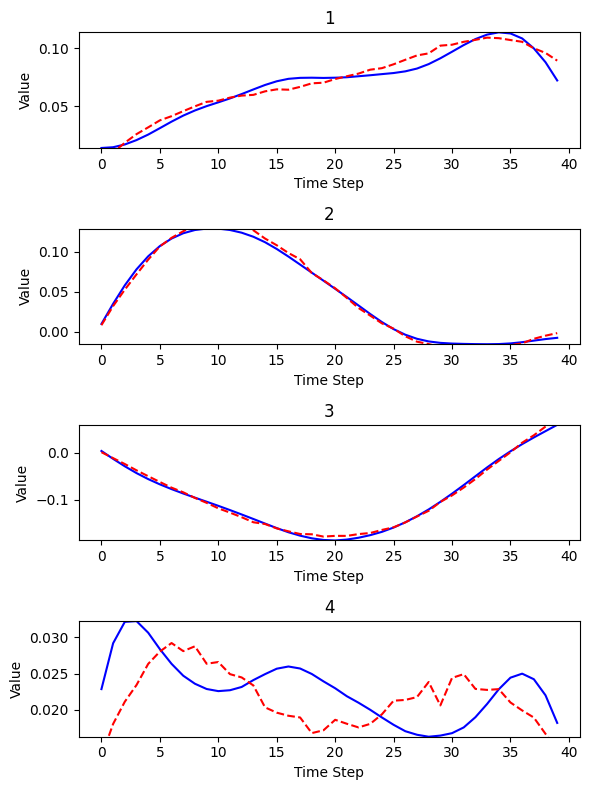

In [11]:
plt.figure(figsize=(6, len(index_) * 2))
for i, idx in enumerate(index_):
    plt.subplot(len(index_), 1, i + 1)
    plt.plot(original_sequence[i, 0, :], label="Original", color="blue")
    plt.plot(reconstructed_sequence[i, 0, :], label="Reconstructed", color="red", linestyle="dashed")
    plt.title(f"{idx}")
    plt.xlabel("Time Step")
    plt.ylabel("Value")
    plt.ylim([min(original_sequence[i, 0, :]), max(original_sequence[i, 0, :])])
    # plt.legend()

plt.tight_layout()
plt.show()

## Look at encoded features

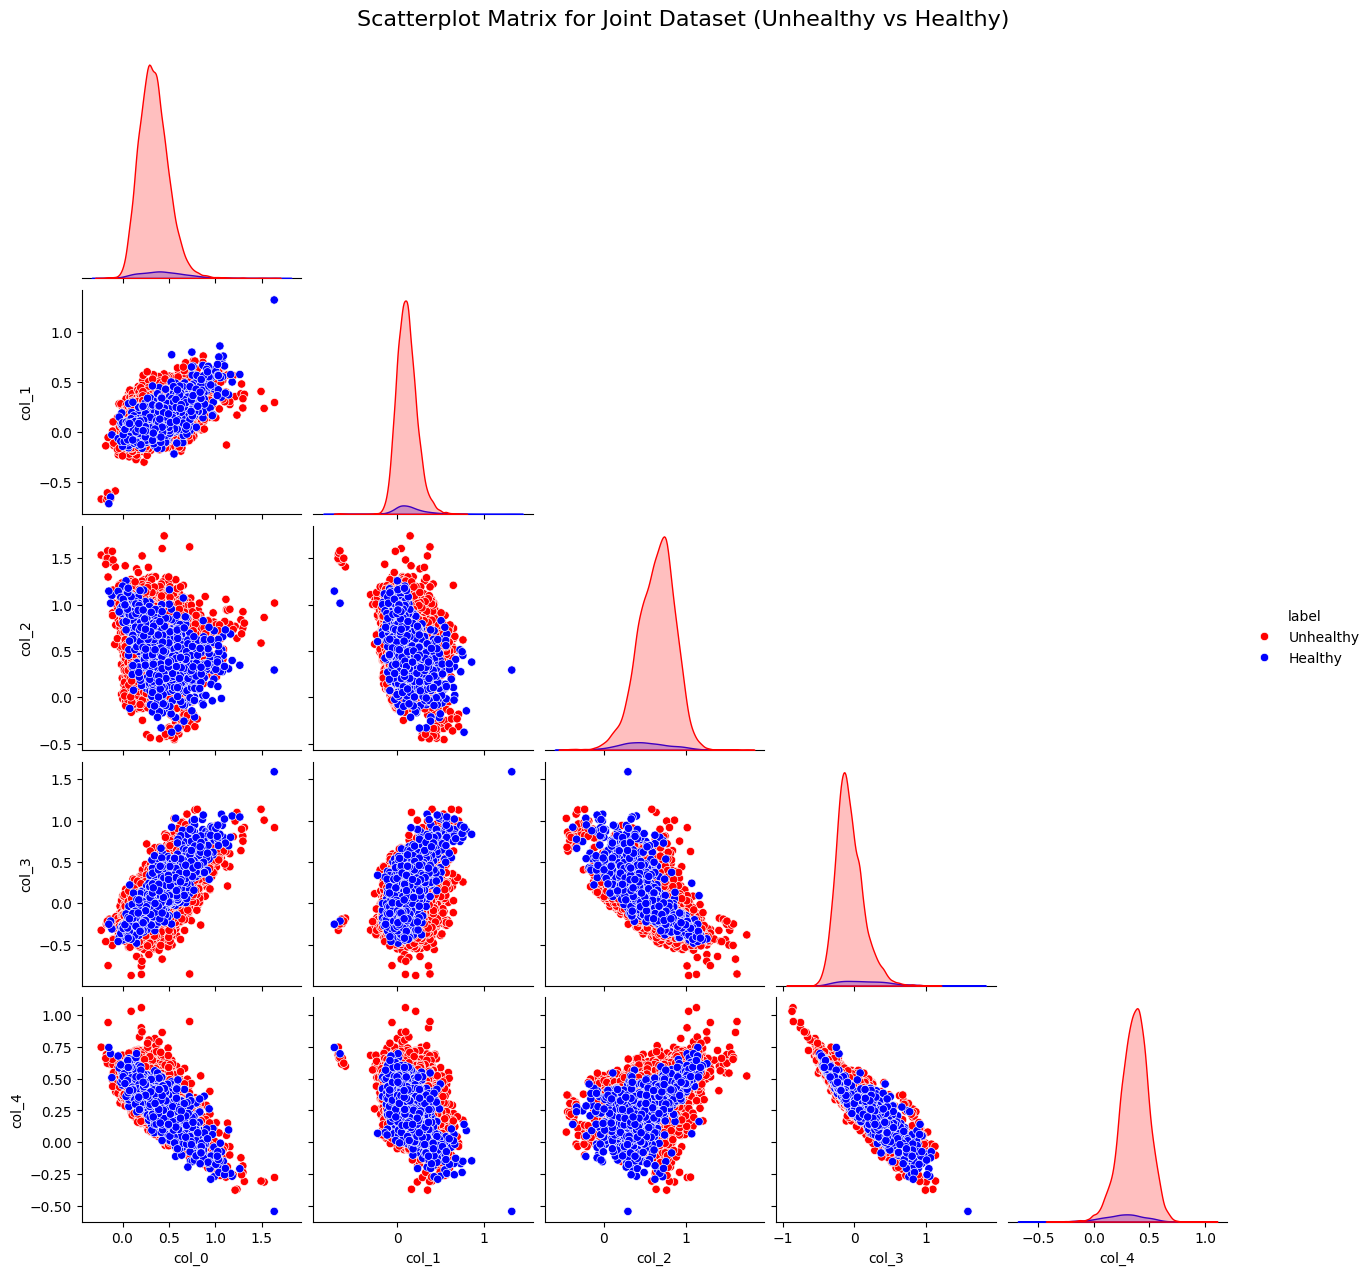

In [12]:
encoded_healthy = model.encode(x).squeeze(1).detach().numpy()

# subject_id_subset_knee = GRF_Annotation[GRF_Annotation['CLASS_LABEL'] == 'K']['SUBJECT_ID'].unique()
subject_id_subset_knee = GRF_Annotation[GRF_Annotation['CLASS_LABEL'] == 'K']['SUBJECT_ID'].unique()
unhealthy_patients = GRF_F_V_PRO_right[GRF_F_V_PRO_right['SUBJECT_ID'].isin(subject_id_subset_knee)]
temp_df = unhealthy_patients.iloc[:,3:] - pointwise_mean
temp_df = temp_df.iloc[:, mask == 1]
# temp_df = temp_df.T.apply(lambda v: v*mask).T
unhealthy_patients_tensor = torch.tensor(temp_df.values, dtype=torch.float32).unsqueeze(1)
encoded_unhealthy = model.encode(unhealthy_patients_tensor).squeeze(1).detach().numpy()

encoded_unhealthy_df = pd.DataFrame(encoded_unhealthy, columns=[f"col_{i}" for i in range(encoded_unhealthy.shape[1])])
encoded_healthy_df = pd.DataFrame(encoded_healthy, columns=[f"col_{i}" for i in range(encoded_healthy.shape[1])])

def scatterplot_matrix_with_means(data, title):
    means = data.mean()  
    g = sns.pairplot(data, diag_kind="kde", corner=True)
    for i, j in zip(*np.tril_indices_from(g.axes, -1)):  
        ax = g.axes[i, j]
        mean_x, mean_y = means.iloc[j], means.iloc[i]
        ax.scatter(mean_x, mean_y, color='red', s=100, label='Sample Mean')
        ax.legend()
    plt.suptitle(title, y=1.02, fontsize=16)
    plt.show()

# scatterplot_matrix_with_means(encoded_unhealthy_df, title="Scatterplot Matrix with Means (Unhealthy)")
# scatterplot_matrix_with_means(encoded_healthy_df, title="Scatterplot Matrix with Means (Healthy)")

encoded_unhealthy_df['label'] = 'Unhealthy'
encoded_healthy_df['label'] = 'Healthy'
joint_dataset = pd.concat([encoded_unhealthy_df, encoded_healthy_df], ignore_index=True)

def scatterplot_matrix_with_labels(data, title):
    g = sns.pairplot(data, diag_kind="kde", hue='label', corner=True, palette={"Unhealthy": "red", "Healthy": "blue"})
    plt.suptitle(title, y=1.02, fontsize=16)
    plt.show()

scatterplot_matrix_with_labels(joint_dataset, title="Scatterplot Matrix for Joint Dataset (Unhealthy vs Healthy)")

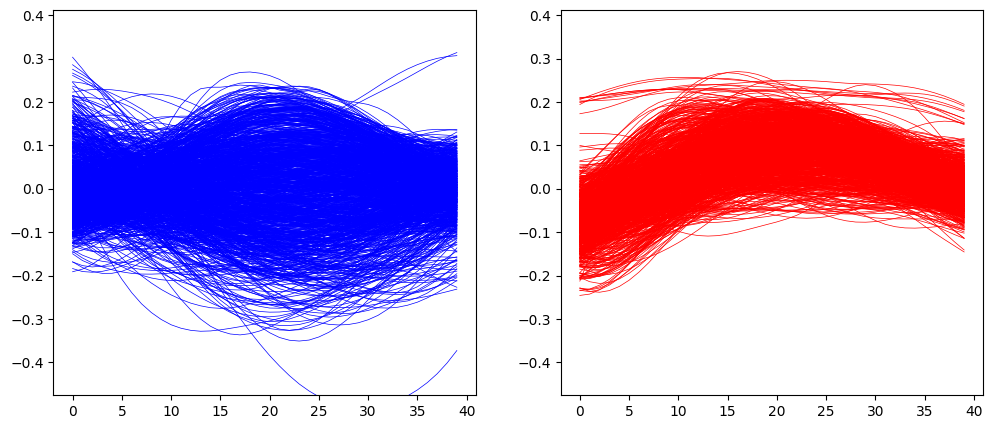

In [13]:
subset_indices = np.random.choice(min([x.shape[0], temp_df.shape[0]]), 1000, replace=False)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].plot(x[subset_indices, 0, :].detach().numpy().T, c='blue', linewidth=0.5)
axes[0].legend([], frameon=False)
axes[0].set_ylim([np.min(temp_df.values), np.max(temp_df.values)])

axes[1].plot(temp_df.values[subset_indices, :].T, c='red', linewidth=0.5)
axes[1].legend([], frameon=False)
axes[1].set_ylim([np.min(temp_df.values), np.max(temp_df.values)])

plt.show()


## Using some sort of depth measure, compute the distribution of the depth measures for the training data

In [14]:
# encoded_unhealthy = encoded_unhealthy[np.random.choice(encoded_unhealthy.shape[0], 7000, replace=False)]
print(encoded_unhealthy.shape)

(19873, 5)


In [15]:
depths_healthy = L2(encoded_healthy, encoded_healthy) # Note: Tuckey depth takes toooooo much time: possible scalability application
depths_unhealthy = L2(encoded_unhealthy, encoded_healthy)

In [16]:
# mean_center = np.mean(encoded_healthy, axis=0)
# depths_healthy = cdist(encoded_healthy, mean_center.reshape(1, -1), metric='euclidean')
# depths_unhealthy = cdist(encoded_unhealthy, mean_center.reshape(1, -1), metric='euclidean')

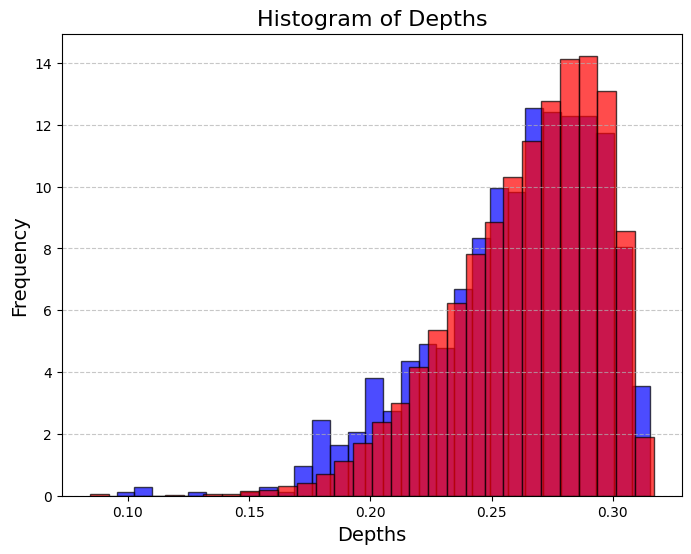

In [17]:
plt.figure(figsize=(8, 6))
plt.hist(depths_healthy, bins=30, color='blue', alpha=0.7, edgecolor='black', density = True)
plt.title("Histogram of Depths", fontsize=16)
plt.xlabel("Depths", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
# plt.axvline(depths_unhealthy[1], color='red', linestyle='--', linewidth=2, label='First Component of Depths Unhealthy')
plt.hist(depths_unhealthy, bins=30, color='red', alpha=0.7, edgecolor='black', density = True)
plt.show()

## Implement a test to understand if we have enought statistical evidence to say that a new patient is different than the ones in our databasse (i.e. the training data, i.e. healthy patients)

In [18]:
stats.kstest(depths_unhealthy, depths_healthy)

KstestResult(statistic=0.05434554420570625, pvalue=0.006951201655861368, statistic_location=0.2597088441541322, statistic_sign=-1)